In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer

In [3]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = Path("datasets/housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"    
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not housing_path.exists():
        housing_path.mkdir(parents=True)
    tgz_path = housing_path / "housing.tgz"
    urllib.request.urlretrieve(housing_url, tgz_path)
    with tarfile.open(tgz_path) as housing_tgz:
        housing_tgz.extractall(path=housing_path)   
        
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = housing_path / "housing.csv"
    return pd.read_csv(csv_path)    

In [ ]:
fetch_housing_data()
housing = load_housing_data()

#Prepare Test set


In [42]:
from zlib import crc32

def is_id_in_test_set(identifier,test_ratio):
    return crc32(np.int64(identifier))  < test_ratio * 2**32

def split_train_with_id_hash(data,test_ratio,id_column):
    ids=data[id_column]
    in_test_set=ids.apply(lambda id_:is_id_in_test_set(id_,test_ratio))
    return data.loc[~in_test_set],data.loc[in_test_set]

housing["id"]=housing["longitude"]*1000+housing["latitude"]
train_set,test_set=split_train_with_id_hash(housing,0.2,"id")

In [43]:
len(train_set),len(test_set)

(13065, 3447)

In [57]:
housing["income_cat"]=pd.cut(housing["median_income"],bins=[0.,1.5,3.0,4.5,6.,np.inf],labels=[1,2,3,4,5])


In [45]:
housing[["income_cat", "median_income"]]

,income_cat,median_income
12655,2,2.1736
15502,5,6.3373
2908,2,2.8750
14053,2,2.2264
20496,3,4.4964
...,...,...
15174,4,5.0900
12661,2,2.8139
19263,3,3.1797
19140,3,4.1964


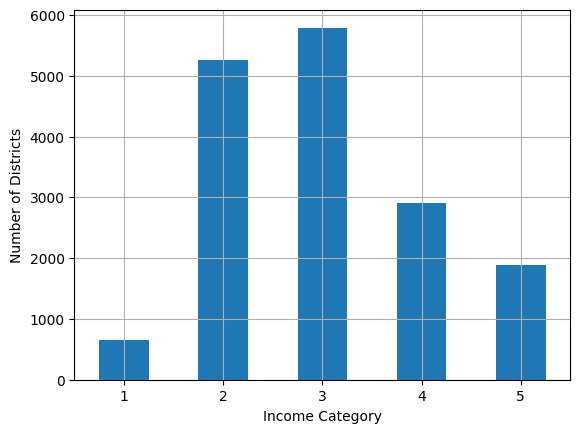

In [46]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0,grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of Districts")
plt.show()

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit
splitter=StratifiedShuffleSplit(n_splits=10,test_size=0.2,random_state=42)

In [58]:
strat_split=[]

for train_index,test_index in splitter.split(housing,housing["income_cat"]):
    strat_train_set_n=housing.loc[train_index]
    strat_test_set_n=housing.loc[test_index]
    strat_split.append((strat_train_set_n,strat_test_set_n))
    
strat_train_set,strat_test_set=strat_split[0]

In [18]:
(len(strat_train_set),len(strat_test_set))

(16512, 4128)

Or you can use simple split method of stratified.

In [52]:
from sklearn.model_selection import train_test_split
strat_train_set,strat_test_set=train_test_split(housing,test_size=0.2,random_state=42,stratify=housing["income_cat"])

No need of income cat now , we have test set and train set with all categories of income. 

In [48]:
for set_ in (strat_train_set,strat_test_set):
    set_.drop("income_cat",axis=1,inplace=True)

Visualizing Data

- radius of circle represent district's population
- color represent the price
 - blue (low value )
 -  red (high value)

<Axes: xlabel='longitude', ylabel='latitude'>

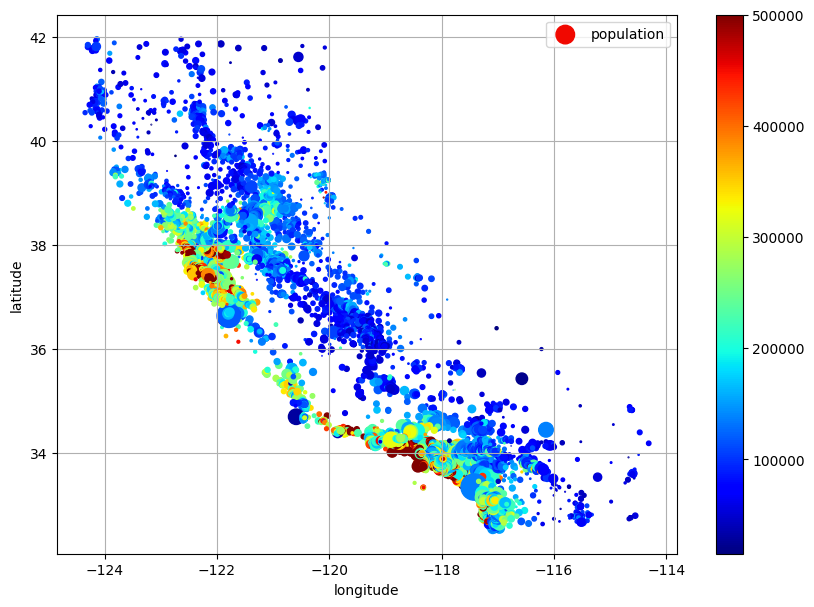

In [59]:
housing.plot(kind="scatter",x="longitude",y="latitude",grid=True,
             s=housing["population"]/100,label="population",
            c=housing["median_house_value"],cmap="jet",
             colorbar=True,legend=True,sharex=False,figsize=(10,7))

Correlations between price and other factor

In [62]:
corr_matrix=housing.select_dtypes(include=[np.number]).corr()

In [34]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,id
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,1.000000
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.924323
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,-0.105921
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.048915
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.076684
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,0.108055
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.063125
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,-0.019715
id,1.000000,-0.924323,-0.105921,0.048915,0.076684,0.108055,0.063125,-0.019715,1.000000


In [63]:
corr_matrix["median_house_value"]

longitude            -0.045967
latitude             -0.144160
housing_median_age    0.105623
total_rooms           0.134153
total_bedrooms        0.049686
population           -0.024650
households            0.065843
median_income         0.688075
median_house_value    1.000000
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='longitude', ylabel='longitude'>,
        <Axes: xlabel='latitude', ylabel='longitude'>,
        <Axes: xlabel='housing_median_age', ylabel='longitude'>,
        <Axes: xlabel='total_rooms', ylabel='longitude'>,
        <Axes: xlabel='total_bedrooms', ylabel='longitude'>,
        <Axes: xlabel='population', ylabel='longitude'>,
        <Axes: xlabel='households', ylabel='longitude'>,
        <Axes: xlabel='median_income', ylabel='longitude'>,
        <Axes: xlabel='median_house_value', ylabel='longitude'>,
        <Axes: xlabel='id', ylabel='longitude'>],
       [<Axes: xlabel='longitude', ylabel='latitude'>,
        <Axes: xlabel='latitude', ylabel='latitude'>,
        <Axes: xlabel='housing_median_age', ylabel='latitude'>,
        <Axes: xlabel='total_rooms', ylabel='latitude'>,
        <Axes: xlabel='total_bedrooms', ylabel='latitude'>,
        <Axes: xlabel='population', ylabel='latitude'>,
        <Axes: xlabel='households', ylabel='latitude'>,
        <Axes:

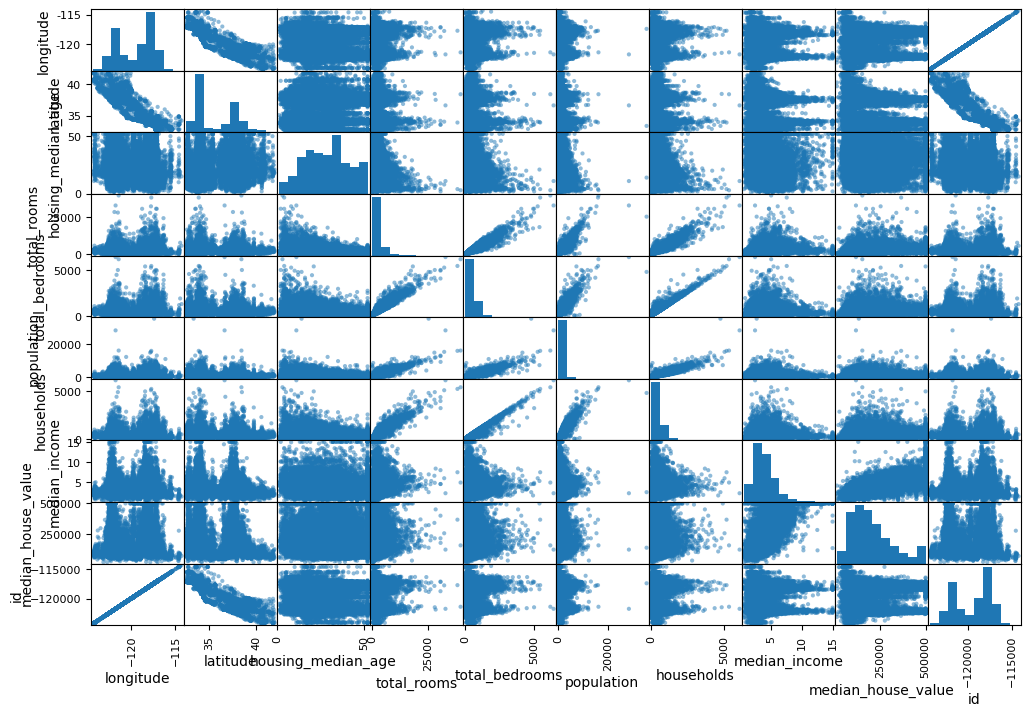

In [29]:
from pandas.plotting import scatter_matrix
scatter_matrix(housing,figsize=(12,8))

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

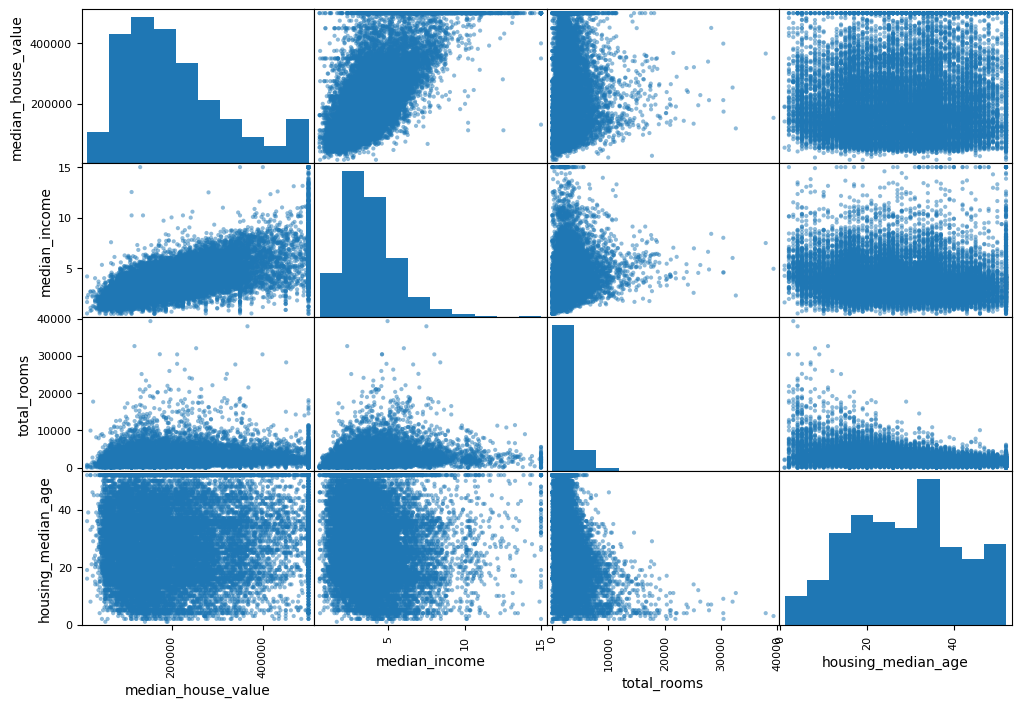

In [30]:
attribute=["median_house_value","median_income","total_rooms","housing_median_age"] 
scatter_matrix(housing[attribute],figsize=(12,8))

In [64]:
housing=strat_train_set.drop("median_house_value",axis=1)
housing_labels=strat_train_set["median_house_value"].copy()

In [65]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,2
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,5
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND,2
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,2
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,3
...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,<1H OCEAN,4
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,INLAND,2
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,<1H OCEAN,3
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,<1H OCEAN,3
